## Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, 'E:\\PINNs\\Utilities')
import torch
from collections import OrderedDict
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
np.random.seed(1234)
import scipy.io
from sklearn.cluster import AgglomerativeClustering

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
class PhysicsInformedNN():
    def __init__(self, X_u, u, layers, lb, ub, attribute, f_points_number=2000): 
        self.attribute=attribute
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        self.weight_decay=1e-4 # L2 正则化参数
        # data (for u)
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=False).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=False).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # collocation points (for f)
        self.f_points_number = f_points_number
        X_f = self.get_f_points(f_points_number)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
                
        # DNN
        self.dnn = DNN(layers).to(device)
                
        # optimizers
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=3000, 
            history_size=50,
            line_search_fn="strong_wolfe"
        )
        if attribute=='teacher':
            self.optimizer_AdamW = torch.optim.AdamW(self.dnn.parameters(), lr=1e-3)
        else:
            self.optimizer_AdamW = torch.optim.AdamW(self.dnn.parameters(), lr=1e-3,weight_decay=self.weight_decay)

    def get_f_points(self, f_points_number):
        """
        构造残差点 X_f_train:
        - x 维度：使用 Beta(2,2) 分布采样，然后变换到 [x_min, x_max]
        - t 维度：使用均匀分布在 [t_min, t_max] 上采样
        """
        x_min, x_max = self.lb[0].item(), self.ub[0].item()
        t_min, t_max = self.lb[1].item(), self.ub[1].item()
        beta_dist = stats.beta(a=2, b=2)
        x_beta_samples = beta_dist.rvs(size=f_points_number)
        
        # 将 Beta 分布的样本变换到 [x_min, x_max]
        x_samples = x_min + (x_max - x_min) * x_beta_samples
        
        # t 维度使用均匀分布
        t_samples = np.random.uniform(t_min, t_max, size=f_points_number)
        
        # 合并 x 和 t 样本
        X_f = np.column_stack([x_samples, t_samples])
        
        return X_f

    def net_u(self, x, t):  
        return self.dnn(torch.cat([x, t], dim=1))
    
    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        
        f = u_t +  u * u_x - 0.01/np.pi * u_xx
        return f
    
    def loss_func(self):
        # Data loss
        u_pred = self.net_u(self.x_u, self.t_u)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        # Physics loss
        if self.attribute=='teacher':
            f_pred = self.net_f(self.x_f, self.t_f)
            loss_f = torch.mean(f_pred ** 2)
            loss = loss_u + loss_f
        else:
            l2_reg = sum(torch.sum(param ** 2) for param in self.dnn.parameters())
            loss = loss_u + self.weight_decay* l2_reg
            loss_f = torch.tensor(0.0)
        loss.backward()
        print('L-BFGS Loss: %.3e, Loss_u: %.3e, Loss_f: %.3e' % 
              (loss.item(), loss_u.item(), loss_f.item()))
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        print('Starting AdamW optimization.')
        for epoch in range(1,nIter+1):
            u_pred = self.net_u(self.x_u, self.t_u)
            loss_u = torch.mean((self.u - u_pred) ** 2)
            if self.attribute=='teacher':
                f_pred = self.net_f(self.x_f, self.t_f)
                loss_f = torch.mean(f_pred ** 2)
                loss = loss_u + loss_f
            else:
                loss = loss_u
                loss_f = torch.tensor(0.0)
            self.optimizer_AdamW.zero_grad()
            loss.backward()
            self.optimizer_AdamW.step()
            
            if epoch % 100 == 0:
                print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_f: %.3e' % 
                      (epoch, loss.item(), loss_u.item(), loss_f.item()))
                X_f=self.get_f_points(self.f_points_number)
                if self.attribute=='teacher':
                    self.x_f,self.t_f=torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device),torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        
        print('Starting L-BFGS optimization.')
        self.optimizer.step(self.loss_func)
        print('Finished L-BFGS optimization.')

    def predict(self, X):
        self.dnn.eval()
        x = torch.tensor(X[:, 0:1]).float().to(device)
        t = torch.tensor(X[:, 1:2]).float().to(device)
        self.dnn.eval()
        u = self.net_u(x, t)
        return u.detach().cpu().numpy()

## Configurations

In [5]:
N_u = 2000
layers = [2,20,40,60,40,20,1]

data = scipy.io.loadmat('E:\\PINNs\\appendix\\Data\\burgers_shock.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 
# ==================== 构造观测数据点 X_u_train (含初边值) ====================
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_interior = X_star[idx, :]
u_interior = u_star[idx, :]

# Add initial condition: t = 0
idx_init = np.where(np.abs(X_star[:, 1] - t.min()) < 1e-6)[0]
X_init = X_star[idx_init, :]
u_init = u_star[idx_init, :]

# Add boundary conditions: x = -1 and x = 1
idx_bnd_left = np.where(np.abs(X_star[:, 0] - x.min()) < 1e-6)[0]
idx_bnd_right = np.where(np.abs(X_star[:, 0] - x.max()) < 1e-6)[0]
X_bnd = X_star[np.concatenate([idx_bnd_left, idx_bnd_right]), :]
u_bnd = u_star[np.concatenate([idx_bnd_left, idx_bnd_right]), :]

# Combine all observation points
X_u_train = np.vstack([X_u_interior, X_init, X_bnd])
u_train = np.vstack([u_interior, u_init, u_bnd])

## Step1:Trainning teacher

In [6]:
teacher = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub,'teacher')
teacher.train(10000)

Starting AdamW optimization.
It: 100, Loss: 1.602e-01, Loss_u: 1.336e-01, Loss_f: 2.659e-02
It: 200, Loss: 1.026e-01, Loss_u: 8.370e-02, Loss_f: 1.894e-02
It: 300, Loss: 7.320e-02, Loss_u: 6.048e-02, Loss_f: 1.272e-02
It: 400, Loss: 4.028e-02, Loss_u: 2.951e-02, Loss_f: 1.077e-02
It: 500, Loss: 2.588e-02, Loss_u: 1.783e-02, Loss_f: 8.043e-03
It: 600, Loss: 1.799e-02, Loss_u: 1.202e-02, Loss_f: 5.979e-03
It: 700, Loss: 1.922e-02, Loss_u: 1.356e-02, Loss_f: 5.657e-03
It: 800, Loss: 1.706e-02, Loss_u: 1.125e-02, Loss_f: 5.818e-03
It: 900, Loss: 1.522e-02, Loss_u: 1.009e-02, Loss_f: 5.131e-03
It: 1000, Loss: 1.386e-02, Loss_u: 9.126e-03, Loss_f: 4.729e-03
It: 1100, Loss: 1.907e-02, Loss_u: 8.701e-03, Loss_f: 1.037e-02
It: 1200, Loss: 1.175e-02, Loss_u: 7.865e-03, Loss_f: 3.884e-03
It: 1300, Loss: 3.161e-02, Loss_u: 2.633e-02, Loss_f: 5.279e-03
It: 1400, Loss: 1.929e-02, Loss_u: 1.541e-02, Loss_f: 3.879e-03
It: 1500, Loss: 1.546e-02, Loss_u: 1.168e-02, Loss_f: 3.785e-03
It: 1600, Loss: 1.33

In [7]:
u_pred = teacher.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u of teacher: %e' % (error_u))                     


Error u of teacher: 3.224943e-02


In [8]:
## Step2:Distill

In [9]:
#获取教师网络的预测作为新的训练数据
distill_point_number = 10000
X_interior=teacher.get_f_points(distill_point_number)
u_interior = teacher.predict(X_interior)
u_bnd=teacher.predict(X_bnd)
u_init=teacher.predict(X_init)
X_distill= np.vstack([X_interior, X_bnd, X_init])
u_distill= np.vstack([u_interior, u_bnd, u_init])

#基于蒸馏数据训练学生网络
student = PhysicsInformedNN(X_distill, u_distill, layers, lb, ub,'student')
student.train(10000)
u_pred_student = student.predict(X_star)
error_u_student = np.linalg.norm(u_star-u_pred_student,2)/np.linalg.norm(u_star,2)
print('Error u of student: %e' % (error_u_student))

Starting AdamW optimization.
It: 100, Loss: 6.067e-02, Loss_u: 6.067e-02, Loss_f: 0.000e+00
It: 200, Loss: 2.356e-02, Loss_u: 2.356e-02, Loss_f: 0.000e+00
It: 300, Loss: 1.450e-02, Loss_u: 1.450e-02, Loss_f: 0.000e+00
It: 400, Loss: 5.752e-03, Loss_u: 5.752e-03, Loss_f: 0.000e+00
It: 500, Loss: 2.919e-03, Loss_u: 2.919e-03, Loss_f: 0.000e+00
It: 600, Loss: 1.871e-03, Loss_u: 1.871e-03, Loss_f: 0.000e+00
It: 700, Loss: 1.370e-03, Loss_u: 1.370e-03, Loss_f: 0.000e+00
It: 800, Loss: 1.047e-03, Loss_u: 1.047e-03, Loss_f: 0.000e+00
It: 900, Loss: 7.832e-04, Loss_u: 7.832e-04, Loss_f: 0.000e+00
It: 1000, Loss: 6.855e-04, Loss_u: 6.855e-04, Loss_f: 0.000e+00
It: 1100, Loss: 4.440e-04, Loss_u: 4.440e-04, Loss_f: 0.000e+00
It: 1200, Loss: 3.557e-04, Loss_u: 3.557e-04, Loss_f: 0.000e+00
It: 1300, Loss: 2.858e-04, Loss_u: 2.858e-04, Loss_f: 0.000e+00
It: 1400, Loss: 2.487e-04, Loss_u: 2.487e-04, Loss_f: 0.000e+00
It: 1500, Loss: 2.040e-04, Loss_u: 2.040e-04, Loss_f: 0.000e+00
It: 1600, Loss: 2.05

## Step3:Structure Extraction

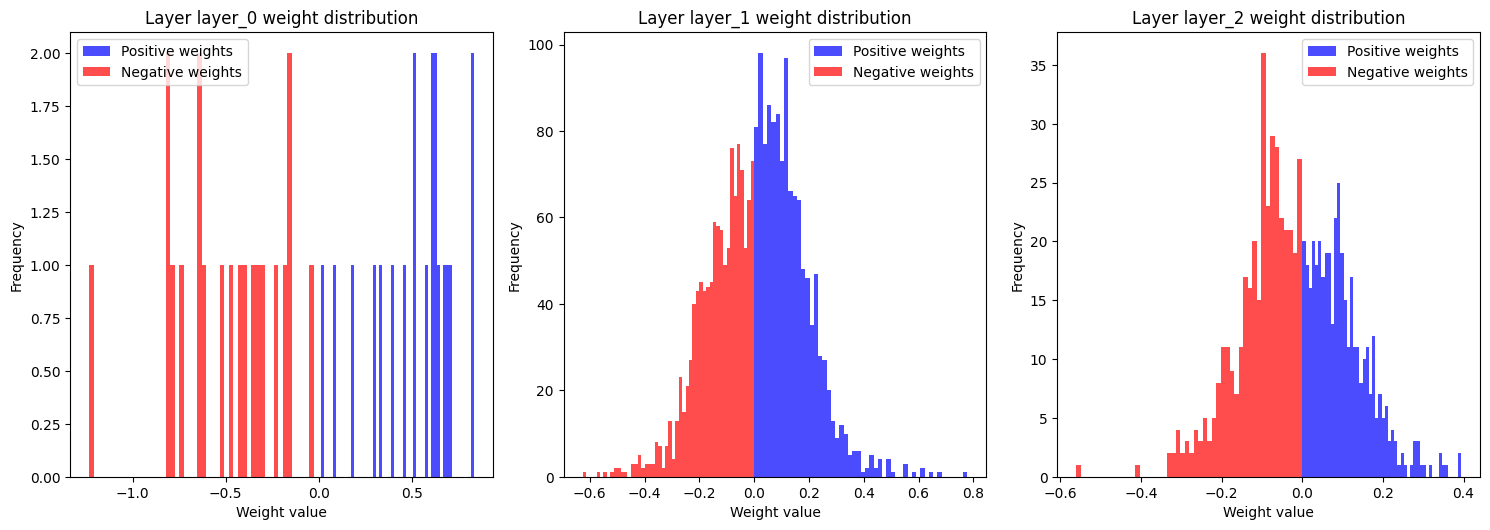

In [ ]:
distance_threshold = 0.001  # 聚类距离阈值
# =============== 权重提取函数 ===============
def extract_weights(model):
    """从模型中提取权重和偏置，保留原始结构"""
    weights = []
    layer_info = []
    
    for name, param in model.dnn.named_parameters():
        layer_name = name.split('.')[1]  # 获取层名
        layer_type = 'weight' if 'weight' in name else 'bias'
        
        if layer_type == 'weight':
            weights.append(param.data.cpu().numpy())
            layer_info.append({
                'name': layer_name,
                'type': layer_type,
                'shape': param.shape
            })
    
    return weights,  layer_info

# =============== 提取学生网络权重 ===============
student_weights, layer_info = extract_weights(student)

# =============== 可视化原始权重分布 ===============
plt.figure(figsize=(15, 10))
for i, (w, info) in enumerate(zip(student_weights, layer_info)):
    if 'weight' not in info['type']:
        continue
        
    plt.subplot(2, 3, i//2+1)
    pos_weights = w[w > 0].flatten()
    neg_weights = w[w < 0].flatten()
    
    if len(pos_weights) > 0:
        plt.hist(pos_weights, bins=50, alpha=0.7, color='blue', label='Positive weights')
    if len(neg_weights) > 0:
        plt.hist(neg_weights, bins=50, alpha=0.7, color='red', label='Negative weights')
        
    plt.title(f"Layer {info['name']} weight distribution")
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.savefig('weight_distribution_with_sign.png')
plt.show()

In [31]:
# =============== 聚类 ===============
def cluster_weights_with_sign(weights, distance_threshold):
    """
    按照欧式距离对参数聚类，区分正负权重并保留符号关系
    """
    clustered_weights = []
    cluster_centers = []
    relation_matrices = []  # 存储关系矩阵R
    
    for i, w in enumerate(weights):
        # 保留原始形状信息
        original_shape = w.shape #例如(20, 40)
        #这个信息很重要，因为后续需要把一维的参数向量重新 reshape 回原来的二维结构
        total_elements = np.prod(original_shape)
        flat_weights = w.flatten()

        # 区分非零和零
        nonzero_mask = flat_weights != 0
        zero_mask = flat_weights == 0
        nonzero_weights = flat_weights[nonzero_mask]

        if nonzero_weights.size > 0:
            # 对绝对值聚类
            abs_weights = np.abs(nonzero_weights)
            n_unique = np.unique(abs_weights).size
            
            if n_unique > 1:
                clustering = AgglomerativeClustering(
                    n_clusters=None,
                    distance_threshold=distance_threshold,
                    linkage='ward'
                )
                clusters = clustering.fit_predict(abs_weights.reshape(-1, 1))
                unique_labels = np.unique(clusters)
                centers = [np.mean(abs_weights[clusters == label]) for label in unique_labels]
            else:
                clusters = np.zeros_like(abs_weights, dtype=int)
                centers = [np.mean(abs_weights)]
        else:
            clusters = None
            centers = []

        
        # 构建关系矩阵 R
        n_clusters = len(centers)
        n_zero_clusters = 1 if np.any(zero_mask) else 0
        n_total_clusters = n_clusters + n_zero_clusters

        R = np.zeros((total_elements, n_total_clusters))
        clustered_w = np.zeros_like(w)

        cluster_idx = 0

        # 非零权重部分（统一处理）
        if nonzero_weights.size > 0:
            nonzero_indices = np.where(nonzero_mask.flatten())[0]  # 在 flat_weights 中的位置
            
            for label in range(len(centers)):
                # 找出属于该聚类的非零权重索引（在 nonzero_weights 中）
                label_indices_in_nonzero = np.where(clusters == label)[0]
                # 映射回 flat_weights 的索引
                original_indices = nonzero_indices[label_indices_in_nonzero]
                
                # 获取原始符号
                signs = np.sign(flat_weights[original_indices])  # +1 or -1
                
                # 填充聚类权重（带符号）
                for idx, sign in zip(original_indices, signs):
                    pos = np.unravel_index(idx, original_shape)
                    clustered_w[pos] = sign * centers[label]
                
                # 构建 R：用符号作为系数
                R[original_indices, cluster_idx] = signs  # ← 关键：+1 或 -1
                cluster_idx += 1

            
                
        # 收集结果
        clustered_weights.append(clustered_w)
        cluster_centers.append({
            'abs': np.array(centers),
            'zero': np.array([0.0]) if np.any(zero_mask) else np.array([])
        })
        relation_matrices.append(R)
        
    
    return clustered_weights, cluster_centers, relation_matrices

# =============== 应用聚类 ===============
clustered_weights, cluster_centers, relation_matrices = cluster_weights_with_sign(student_weights, distance_threshold)

# =============== 创建低秩结构 ===============
def create_low_rank_structure(weights, relation_matrices, cluster_centers):
    low_rank_weights = []
    
    for i, (w, R, centers) in enumerate(zip(weights, relation_matrices, cluster_centers)):
        unique_params = []
        if 'abs' in centers and centers['abs'].size > 0:
            unique_params.extend(centers['abs'])  # 这些是绝对值的均值，>0
        if 'zero' in centers and centers['zero'].size > 0:
            unique_params.append(0.0)
        
        # 确保长度匹配
        if len(unique_params) != R.shape[1]:
            print(f"Warning: Dimension mismatch in layer {i}. R columns: {R.shape[1]}, unique_params: {len(unique_params)}")
            if len(unique_params) < R.shape[1]:
                # 填充额外的零
                unique_params.extend([0.0] * (R.shape[1] - len(unique_params)))
            else:
                # 截断
                unique_params = unique_params[:R.shape[1]]
        
        phi = np.array(unique_params).reshape(-1, 1)
        
        # 重建权重矩阵
        reconstructed_w = R @ phi
        
        # 调整形状以匹配原始权重
        if reconstructed_w.shape != w.shape:
            if reconstructed_w.size == w.size:
                reconstructed_w = reconstructed_w.reshape(w.shape)
            else:
                # 特殊情况：填充或裁剪
                temp = np.zeros_like(w)
                min_size = min(temp.size, reconstructed_w.size)
                temp.flat[:min_size] = reconstructed_w.flat[:min_size]
                reconstructed_w = temp
        
        low_rank_weights.append(reconstructed_w)
        
        # 物理结构分析
        if i == 0:  # 输入层
            print("\nPhysical structure analysis for input layer:")
            if len(reconstructed_w.shape) >= 2 and reconstructed_w.shape[1] >= 2:  # 至少有2个输入(x,t)
                x_weights = reconstructed_w[:, 0]
                t_weights = reconstructed_w[:, 1]
                correlation = np.corrcoef(x_weights, t_weights)[0, 1]
                print(f"  Correlation between x and t weights: {correlation:.4f}")
                
                if len(x_weights) > 1:
                    symmetry_score = np.abs(np.mean(x_weights[::2] + x_weights[1::2]))
                    print(f"  X-weights symmetry score: {symmetry_score:.4f}")
    
    return low_rank_weights

# =============== 生成低秩权重 ===============
low_rank_weights = create_low_rank_structure(student_weights, relation_matrices, cluster_centers)

# =============== 每层聚类与对称性分析（纯文本） ===============
print("\n" + "="*60)
print("Ψ-NN Layer-wise Clustering and Symmetry Analysis")
print("="*60)

for i, (w, centers, info) in enumerate(zip(student_weights, cluster_centers, layer_info)):
    layer_name = info.get('name', f'Layer_{i}')
    
    # 参数统计
    orig_count = w.size
    unique_count = 0
    if 'abs' in centers and centers['abs'].size > 0:
        unique_count += centers['abs'].size
    if 'zero' in centers and centers['zero'].size > 0:
        unique_count += 1  # 零作为一个唯一值
    
    compression_ratio = unique_count / orig_count if orig_count > 0 else 0
    reduction_pct = (1 - compression_ratio) * 100

    print(f"\n{layer_name}:")
    print(f"  Original parameters: {orig_count}")
    print(f"  Unique parameters after clustering: {unique_count}")
    print(f"  Compression ratio: {compression_ratio:.4f} ({reduction_pct:.2f}% reduction)")

    # === 对称性分析：仅对输入层（假设是第一个权重层，且有2列：x, t）===
    if i == 0 and w.ndim == 2 and w.shape[1] >= 2:
        x_weights = w[:, 0]  # 假设第0列是x的权重
        n = len(x_weights)

        # 方法：检查是否存在成对的 (a, -a) —— 反对称（奇函数特性）
        # 我们将权重排序后，尝试首尾配对
        sorted_idx = np.argsort(x_weights)
        sorted_w = x_weights[sorted_idx]

        tol = 1e-3  # 对称容忍度
        matched_pairs = 0
        used = np.zeros(n, dtype=bool)

        # 从两端向中间匹配
        left, right = 0, n - 1
        while left < right:
            if used[left]:
                left += 1
                continue
            if used[right]:
                right -= 1
                continue
            if abs(sorted_w[left] + sorted_w[right]) < tol:
                matched_pairs += 1
                used[left] = True
                used[right] = True
                left += 1
                right -= 1
            elif sorted_w[left] + sorted_w[right] < -tol:
                left += 1  # 左边太负，需更大（更接近0）
            else:
                right -= 1  # 右边太正，需更小

        unmatched = n - 2 * matched_pairs
        antisym_ratio = (2 * matched_pairs) / n if n > 0 else 0

        print(f"  Input layer (x-weights) symmetry analysis:")
        print(f"    Total neurons: {n}")
        print(f"    Antisymmetric (odd) pairs found: {matched_pairs}")
        print(f"    Matched weights: {2 * matched_pairs} / {n} ({antisym_ratio:.2%})")
        print(f"    Unmatched (asymmetric): {unmatched}")

        # 补充：整体反对称得分（越小越反对称）
        if n % 2 == 0:
            # 假设按顺序成对：(0,1), (2,3), ...
            pair_sum = np.mean(np.abs(x_weights[::2] + x_weights[1::2]))
            print(f"    Sequential pair antisymmetry score: {pair_sum:.4f} (lower is better)")
        else:
            print(f"    Sequential pair analysis skipped (odd number of neurons)")

print("\n" + "="*60)


Physical structure analysis for input layer:
  Correlation between x and t weights: -0.0051
  X-weights symmetry score: 0.1254

Ψ-NN Layer-wise Clustering and Symmetry Analysis

layer_0:
  Original parameters: 40
  Unique parameters after clustering: 40
  Compression ratio: 1.0000 (0.00% reduction)
  Input layer (x-weights) symmetry analysis:
    Total neurons: 20
    Antisymmetric (odd) pairs found: 0
    Matched weights: 0 / 20 (0.00%)
    Unmatched (asymmetric): 20
    Sequential pair antisymmetry score: 0.4438 (lower is better)

layer_0:
  Original parameters: 800
  Unique parameters after clustering: 285
  Compression ratio: 0.3563 (64.38% reduction)

layer_1:
  Original parameters: 2400
  Unique parameters after clustering: 445
  Compression ratio: 0.1854 (81.46% reduction)

layer_1:
  Original parameters: 2400
  Unique parameters after clustering: 415
  Compression ratio: 0.1729 (82.71% reduction)

layer_2:
  Original parameters: 800
  Unique parameters after clustering: 242
  

In [25]:
# =============== Ψ-NN模型定义 ===============
class PsiNeuralNetwork(torch.nn.Module):
    def __init__(self, original_layers, relation_matrices, unique_params):
        super(PsiNeuralNetwork, self).__init__()
        
        self.depth = len(original_layers) - 1
        self.activation = torch.nn.Tanh()
        self.relation_matrices = torch.nn.ParameterList()  # 改为ParameterList
        self.unique_params = torch.nn.ParameterList()
        self.layer_sizes = original_layers  # 保存层大小
        self.weight_shapes = []  # 权重形状
        
        # 设置权重形状
        for i in range(len(original_layers)-1):
            self.weight_shapes.append((original_layers[i+1], original_layers[i]))
        
        # 将关系矩阵和唯一参数转换为PyTorch参数
        for i, (R, phi) in enumerate(zip(relation_matrices, unique_params)):
            # 关系矩阵R是固定的，但需要注册为buffer以随设备移动
            R_tensor = torch.tensor(R, dtype=torch.float32)
            self.register_buffer(f"relation_matrix_{i}", R_tensor)  # 正确注册buffer
            
            # 唯一参数是可学习的
            if isinstance(phi, dict):
                all_params = []
                # 使用 'abs' 字段（绝对值聚类中心，全为正）
                if 'abs' in phi and phi['abs'].size > 0:
                    all_params.extend(phi['abs'].tolist())
                # 零权重（可选，通常不需要）
                if 'zero' in phi and phi['zero'].size > 0:
                    all_params.extend(phi['zero'].tolist())
                phi_tensor = torch.tensor(all_params, dtype=torch.float32).reshape(-1, 1)
            else:
                # 兼容旧格式（直接传数组）
                phi_tensor = torch.tensor(phi, dtype=torch.float32).reshape(-1, 1)
                    
                self.unique_params.append(
                    torch.nn.Parameter(phi_tensor)
                )
    
    def get_relation_matrix(self, idx):
        """获取指定索引的关系矩阵"""
        return getattr(self, f"relation_matrix_{idx}")
    
    def forward(self, x):
        out = x
        for i in range(self.depth):
            if i >= len(self.unique_params):
                break
                
            # 获取关系矩阵
            R = self.get_relation_matrix(i)
            phi = self.unique_params[i]
            
            # 确保维度匹配
            if R.dim() == 1:
                R = R.unsqueeze(0)
            if phi.dim() == 1:
                phi = phi.unsqueeze(1)
            
            # 重建权重
            weight_vector = torch.matmul(R, phi).flatten()
            
            # 重塑权重
            out_features, in_features = self.weight_shapes[i]
            total_elements = out_features * in_features
            
            # 安全处理元素数量
            if weight_vector.numel() != total_elements:
                temp_weights = torch.zeros(total_elements, device=weight_vector.device)
                min_size = min(total_elements, weight_vector.numel())
                temp_weights[:min_size] = weight_vector[:min_size]
                weights = temp_weights.reshape(out_features, in_features)
            else:
                weights = weight_vector.reshape(out_features, in_features)
            
            # 应用线性变换
            out = torch.nn.functional.linear(out, weights)
            
            # 激活函数
            if i < self.depth - 1:
                out = torch.tanh(out)
        
        return out

In [26]:
# 从聚类中心提取唯一参数
unique_params = []
for centers in cluster_centers:
    params = []
    if 'abs' in centers and centers['abs'].size > 0:
        params.extend(centers['abs'].tolist())  # 正值中心
    if 'zero' in centers and centers['zero'].size > 0:
        params.append(0.0)                     
    unique_params.append(np.array(params))      # 每层一个 array

# 创建Ψ-NN模型
psi_nn = PsiNeuralNetwork(layers, relation_matrices, unique_params).to(device)
# =============== 预测函数 ===============
def psi_nn_predict(model, X):
    x = torch.tensor(X[:, 0:1]).float().to(device)
    t = torch.tensor(X[:, 1:2]).float().to(device)
    with torch.no_grad():
        u = model(torch.cat([x, t], dim=1))
    return u.cpu().numpy()

# =============== 评估微调前的Ψ-NN ===============
u_pred_psi = psi_nn_predict(psi_nn, X_star)
error_u_psi = np.linalg.norm(u_star - u_pred_psi, 2) / np.linalg.norm(u_star, 2)
print('Error u of Ψ-NN (before fine-tuning): %e' % (error_u_psi))

# =============== 微调Ψ-NN ===============
def fine_tune_psi_nn(model, X_train, u_train, epochs=2000, lr=1e-3):
    """
    按照论文方法微调Ψ-NN，保持结构不变，仅优化唯一参数
    """
    x_train = torch.tensor(X_train[:, 0:1]).float().to(device)
    t_train = torch.tensor(X_train[:, 1:2]).float().to(device)
    u_train_tensor = torch.tensor(u_train).float().to(device)
    
    optimizer = torch.optim.AdamW(model.unique_params, lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)
    
    best_loss = float('inf')
    best_params = None
    
    print("Fine-tuning Ψ-NN...")
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # 前向传播
        u_pred = model(torch.cat([x_train, t_train], dim=1))
        
        # 计算损失
        
        loss=torch.mean((u_train_tensor - u_pred) ** 2)
        # 反向传播
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        # 保存最佳模型
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params = [param.clone().detach() for param in model.unique_params]
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.3e}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
    
    # 恢复最佳参数
    for param, best_param in zip(model.unique_params, best_params):
        param.data.copy_(best_param)
    
    print(f"Fine-tuning complete. Best loss: {best_loss:.3e}")
    return model

# 微调Ψ-NN
psi_nn = fine_tune_psi_nn(psi_nn, X_distill, u_distill, epochs=6000)

# =============== 评估微调后的Ψ-NN ===============
u_pred_psi_finetuned = psi_nn_predict(psi_nn, X_star)
error_u_psi_finetuned = np.linalg.norm(u_star - u_pred_psi_finetuned, 2) / np.linalg.norm(u_star, 2)
print('Error u of Ψ-NN (after fine-tuning): %e' % (error_u_psi_finetuned))

# =============== 参数压缩分析 ===============
original_params = sum([w.size for w in student_weights])
unique_param_count = sum(
    (centers.get('abs', np.array([])).size + 
     centers.get('zero', np.array([])).size)
    for centers in cluster_centers
)
compression_ratio = unique_param_count / original_params

print(f"\nParameter compression analysis:")
print(f"Original network parameters: {original_params}")
print(f"Ψ-NN unique parameters: {unique_param_count}")
print(f"Compression ratio: {compression_ratio:.4f} ({(1-compression_ratio)*100:.2f}% reduction)")

# =============== 物理结构分析 ===============
print("\nPhysical structure analysis of Ψ-NN:")
for i, (R, centers) in enumerate(zip(relation_matrices, cluster_centers)):
    layer_name = layer_info[i]['name'] if i < len(layer_info) else f"Layer {i}"
    print(f"\n{layer_name} relation matrix analysis:")
    
    # 分析关系矩阵的结构
    n_rows, n_cols = R.shape
    print(f"  Relation matrix shape: {n_rows} x {n_cols}")
    
    # 检测对称性模式
    if n_rows > 1 and n_cols > 1:
        # 检查行间相关性
        row_correlations = np.corrcoef(R)
        avg_correlation = np.mean(np.abs(row_correlations - np.eye(n_rows)))
        print(f"  Average row correlation: {avg_correlation:.4f}")
        
        # 检查是否存在重复模式
        unique_rows = np.unique(np.round(R, decimals=4), axis=0)
        print(f"  Unique row patterns: {len(unique_rows)} out of {n_rows} total rows")

# =============== 保存Ψ-NN模型 ===============
torch.save({
    'relation_matrices': [R.cpu().numpy() for R in psi_nn.relation_matrices],
    'unique_params': [param.cpu().detach().numpy() for param in psi_nn.unique_params],
    'layer_sizes': psi_nn.layer_sizes
}, 'psi_neural_network.pth')
print("\nΨ-NN model saved to 'psi_neural_network.pth'")



Error u of Ψ-NN (before fine-tuning): 7.045005e-01
Fine-tuning Ψ-NN...
Epoch 0, Loss: 1.867e-01, LR: 1.00e-03
Epoch 100, Loss: 3.023e-02, LR: 1.00e-03
Epoch 200, Loss: 1.651e-02, LR: 1.00e-03
Epoch 300, Loss: 9.633e-03, LR: 1.00e-03
Epoch 400, Loss: 6.506e-03, LR: 1.00e-03
Epoch 500, Loss: 4.860e-03, LR: 1.00e-03
Epoch 600, Loss: 3.911e-03, LR: 1.00e-03
Epoch 700, Loss: 3.302e-03, LR: 1.00e-03
Epoch 800, Loss: 2.865e-03, LR: 1.00e-03
Epoch 900, Loss: 2.524e-03, LR: 1.00e-03
Epoch 1000, Loss: 2.242e-03, LR: 1.00e-03
Epoch 1100, Loss: 2.001e-03, LR: 1.00e-03
Epoch 1200, Loss: 1.811e-03, LR: 1.00e-03
Epoch 1300, Loss: 1.710e-03, LR: 1.00e-03
Epoch 1400, Loss: 1.508e-03, LR: 1.00e-03
Epoch 1500, Loss: 1.408e-03, LR: 1.00e-03
Epoch 1600, Loss: 1.294e-03, LR: 1.00e-03
Epoch 1700, Loss: 1.874e-03, LR: 1.00e-03
Epoch 1800, Loss: 1.140e-03, LR: 1.00e-03
Epoch 1900, Loss: 1.075e-03, LR: 1.00e-03
Epoch 2000, Loss: 1.026e-03, LR: 1.00e-03
Epoch 2100, Loss: 9.751e-04, LR: 1.00e-03
Epoch 2200, Loss:

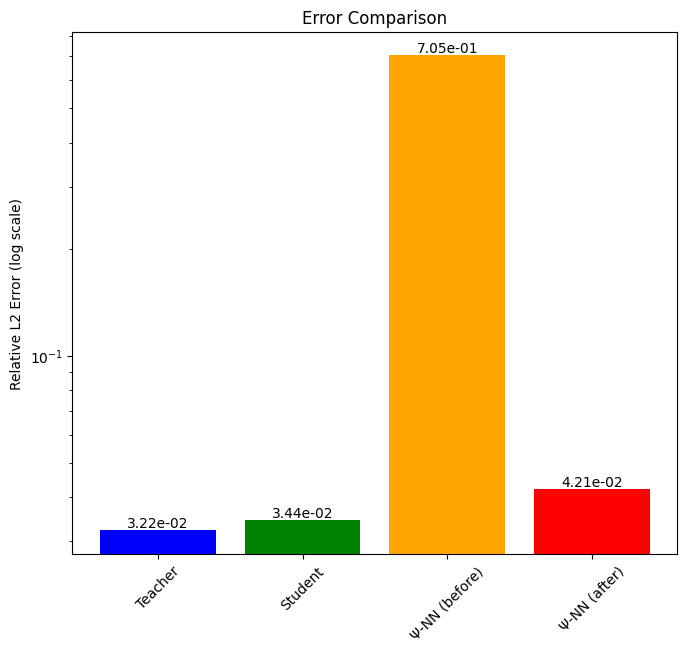

In [27]:
# =============== 生成最终对比图 ===============
plt.figure(figsize=(20, 12))
# 误差比较
x_labels = ['Teacher', 'Student', 'Ψ-NN (before)', 'Ψ-NN (after)']
errors = [error_u, error_u_student, error_u_psi, error_u_psi_finetuned]
plt.subplot(2, 3, 6)
bars = plt.bar(x_labels, errors, color=['blue', 'green', 'orange', 'red'])
plt.yscale('log')
plt.ylabel('Relative L2 Error (log scale)')
plt.title('Error Comparison')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2e}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()